## Plotting activities

* Brute-force searches with 10% and 5% molar fractions
* Bayesian search 

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append('../scripts')
from functions import *

### Load data

In [20]:
#import pandas as pd

# Function to parse a string into a list of floats
def parse_molar_fraction(s): # Helps loading the .csv files! Made with ChatGPT assistance
    # Remove brackets and split by spaces
    values = s.strip('[]').split()

    # Convert each value to float
    return [float(value) for value in values]

def load_csv_activity_data(filename):
    # Load CSV file into a pandas DataFrame
    df = pd.read_csv(filename)

    # Extract columns and convert them to lists
    molar_fractions = df['Molar_Fraction'].tolist()
    estimated_activities = df['Estimated_Activities'].tolist()
    estimated_max_eUs = df['Estimated_Max_eUs'].tolist()

    molar_fractions = np.array([parse_molar_fraction(molar_frac) for molar_frac in molar_fractions])

    return molar_fractions, estimated_activities, estimated_max_eUs


In [21]:
metals

['Ag', 'Au', 'Cu', 'Pd', 'Pt']

In [18]:
path = "../Activity_Estimation/"
filename = "PtAgAu_005_activities.csv"
n_metals = 3
molar_fractions, estimated_activities, estimated_max_eUs = load_csv_activity_data(path+filename)

In [23]:
# I need a function, that takes a list of lists and removes select "columns". By columns I mean the ones I can access if I transpose the 2-dimensional matrix (list of lists) and slice it there

def remove_columns(matrix, columns_to_keep):
    return [list(row[i] for i in columns_to_keep) for row in matrix]

molar_fractions_short = remove_columns(molar_fractions, [0, 1, 4])

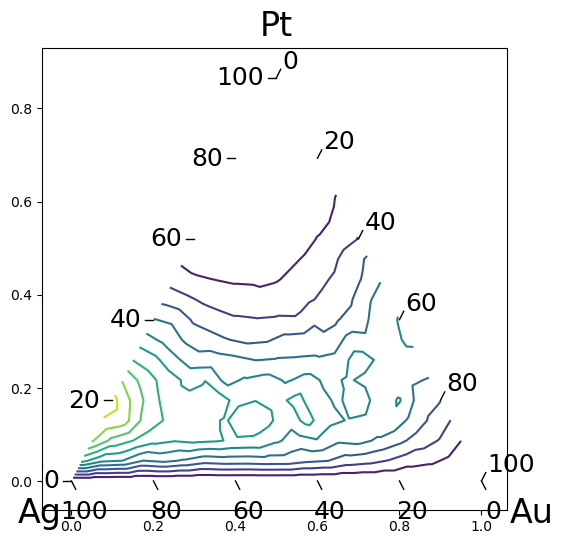

In [27]:
fig, ax = plt.subplots(figsize = (6, 6))

fs = molar_fractions_short
zs = estimated_activities
ax = ax
elems = ["Ag", "Au", "Pt"]
make_ternary_contour_plot(fs, zs, ax, elems)

In [26]:
## All this code was written by Jack . Ref: https://seafile.erda.dk/seafile/d/8586692f13/files/?p=%2Fscripts%2F__init__.py

def get_composition(f, metals, return_latex=False, saferound=True):
	
	# Make into numpy and convert to atomic percent
	f = np.asarray(f)*100
	
	if saferound:
		# Round while maintaining the sum, the iteround module may need
		# to be installed manually from pypi: "pip3 install iteround"
		import iteround
		f = iteround.saferound(f, 0)
	
	if return_latex:
		# Return string in latex format with numbers as subscripts
		return ''.join(['$\\rm {0}_{{{1}}}$'.format(m,f0) for m,f0 in\
			zip(metals, map('{:.0f}'.format, f)) if float(f0) > 0.])
	else:
		# Return composition as plain text
		return ''.join([''.join([m, f0]) for m,f0 in\
			zip(metals, map('{:.0f}'.format, f)) if float(f0) > 0.])
		
def get_simplex_vertices(n_elems=n_metals):

	# Initiate array of vertice coordinates
	vertices = np.zeros((n_elems, n_elems-1))
	
	for idx in range(1, n_elems):
		
		# Get coordinate of the existing dimensions as the 
		# mean of the existing vertices
		vertices[idx] = np.mean(vertices[:idx], axis=0)
		
		# Get the coordinate of the new dimension by ensuring it has a unit 
		# distance to the first vertex at the origin 
		vertices[idx][idx-1] = (1 - np.sum(vertices[idx][:-1]**2))**0.5
		
	return vertices

def molar_fractions_to_cartesians(fs):
	
	# Make into numpy
	fs = np.asarray(fs)

	if fs.ndim == 1:
		fs = np.reshape(fs, (1, -1))

	# Get vertices of the multidimensional simplex
	n_elems = fs.shape[1]
	vertices = get_simplex_vertices(n_elems)	
	vertices_matrix = vertices.T
	
	# Get cartisian coordinates corresponding to the molar fractions
	return np.dot(vertices_matrix, fs.T)

def make_triangle_ticks(ax, start, stop, tick, n, offset=(0., 0.),
						fontsize=18, ha='center', tick_labels=True):
	r = np.linspace(0, 1, n+1)
	x = start[0] * (1 - r) + stop[0] * r
	x = np.vstack((x, x + tick[0]))
	y = start[1] * (1 - r) + stop[1] * r
	y = np.vstack((y, y + tick[1]))
	ax.plot(x, y, 'k', lw=1., zorder=0)
	
	if tick_labels:
	
		# Add tick labels
		for xx, yy, rr in zip(x[0], y[0], r):
			ax.text(xx+offset[0], yy+offset[1], f'{rr*100.:.0f}',
					fontsize=fontsize, ha=ha)

def make_ternary_contour_plot(fs, zs, ax, elems, cmap='viridis', levels=10,
							  color_norm=None, filled=False, axis_labels=False,
							  n_ticks=5, tick_labels=True, corner_labels=True):

	# Get cartesian coordinates corresponding to the molar fractions
	xs, ys = molar_fractions_to_cartesians(fs)
	
	# Make contour plot
	if filled:
		ax.tricontourf(xs, ys, zs, levels=levels, cmap=cmap, norm=color_norm, zorder=0)
	else:
		ax.tricontour(xs, ys, zs, levels=levels, cmap=cmap, norm=color_norm, zorder=0)
	

	# Specify vertices as molar fractions
	fs_vertices = [[1., 0., 0.],
				   [0., 1., 0.],
				   [0., 0., 1.]]
	
	# Get cartesian coordinates of vertices
	xs, ys = molar_fractions_to_cartesians(fs_vertices)
	
	# Make ticks and tick labels on the triangle axes
	left, right, top = np.concatenate((xs.reshape(-1,1), ys.reshape(-1,1)), axis=1)
	
	tick_size = 0.025
	bottom_ticks = 0.8264*tick_size * (right - top)
	right_ticks = 0.8264*tick_size * (top - left)
	left_ticks = 0.8264*tick_size * (left - right)
		
	make_triangle_ticks(ax, right, left, bottom_ticks, n_ticks, offset=(0.03, -0.08), ha='center', tick_labels=tick_labels)
	make_triangle_ticks(ax, left, top, left_ticks, n_ticks, offset=(-0.03, -0.015), ha='right', tick_labels=tick_labels)
	make_triangle_ticks(ax, top, right, right_ticks, n_ticks, offset=(0.015, 0.02), ha='left', tick_labels=tick_labels)

	if axis_labels:	
		# Show axis labels (i.e. atomic percentages)
		ax.text(0.5, -0.12, f'{elems[0]} content (%)', rotation=0., fontsize=20, ha='center', va='center')
		ax.text(0.88, 0.5, f'{elems[1]} content (%)', rotation=-55., fontsize=20, ha='center', va='center')
		ax.text(0.12, 0.5, f'{elems[2]} content (%)', rotation=55., fontsize=20, ha='center', va='center')

	if corner_labels:
		
		# Define padding to put the text neatly
		pad = [[-0.13, -0.09],
			   [ 0.07, -0.09],
			   [-0.04,  0.09]]
		
		# Show the chemical symbol as text at each vertex
		for idx, (x, y, (dx, dy)) in enumerate(zip(xs, ys, pad)):
			ax.text(x+dx, y+dy, s=elems[idx], fontsize=24)